In [ ]:
#library imports
import os, cv2, json, numpy as np, pandas as pd
from datetime import datetime
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import backend as K
from sklearn.metrics import (classification_report, confusion_matrix,
                             balanced_accuracy_score, f1_score, auc)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from pathlib import Path



In [ ]:
#.....................General Configurations...............................

#class to keep model settings in one place
class Flags:
    dim_hidden = 512          #size of the LSTM/hidden layers in the head
    ratio = 8                 #channel attention reduction ratio (smaller = more compression)
    learning_rate = 1e-5      #how fast the optimizer learns
    num_classes = 7           #number of skin lesion classes
    input_shape = (224, 224, 3)  #image size + 3 color channels (RGB)

#class names in the order used during training
CLASS_NAMES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
IMG_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)
np.set_printoptions(suppress=True, linewidth=120) #settings for printing

#promoting Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

#path to save the sample results
RESULTS_DIR = "/content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam"


In [ ]:
#Utility functions
#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#read an ISIC 2018 CSV and return a DataFrame with labels and ids
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)

    #ensure that the image identifier column exists
    if 'image' not in df.columns:
        raise ValueError("Expected column 'image' in ground-truth CSV")

    #create "<id>.jpg"
    df['new_image_id'] = df['image'].astype(str) + ".jpg"

    #one-hot columns in ISIC 2018 data
    diagnosis_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    #convert the one-hot to label index
    #from the one-hot row choose the column name with the maximum value '1' or the string class label
    df['label'] = df[diagnosis_cols].idxmax(axis=1)

    #map string labels to integer indices 0..6 in a fixed, known order
    label_mapping = {cls:i for i, cls in enumerate(diagnosis_cols)}
    df['label'] = df['label'].map(label_mapping)
    return df

#load images listed in a dataframe, preprocess them and return as arrays
def load_images(df, img_dir, size=IMG_SIZE):
    X, y, ids = [], [], []

    #iterate over each row or image entry in the data frame
    for _, row in df.iterrows():

        #build path
        p = os.path.join(img_dir, row['new_image_id'])

        #skip this if the file is missing
        if not os.path.exists(p):
            continue

        img = cv2.imread(p)
        if img is None:
            continue

        #convert BGR to RGB to match the Keras expectations
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) #resize to the model's expected input size
        img = img.astype('float32') / 255.0  #normalization

        #get the sample and its label and filename
        X.append(img); y.append(int(row['label'])); ids.append(row['new_image_id'])

    X = np.array(X, dtype='float32')
    y = np.array(y, dtype=np.int32)
    return X, y, ids

#a quick recursive health check for the image directory,
#counts how many image filesare seen for common extensions and shows a few example paths
def sanity_check_dir(img_dir):
    p = Path(img_dir)
    print(f"[sanity] dir: {img_dir} | exists={p.exists()} is_dir={p.is_dir()}")
    counts = {}
    samples = []

    #search for common image extensions - both lower/upper case
    for pat in ["**/*.jpg","**/*.JPG","**/*.jpeg","**/*.JPEG","**/*.png","**/*.PNG","**/*.tif","**/*.TIF","**/*.tiff","**/*.TIFF"]:
        found = list(p.rglob(pat))
        counts[pat] = len(found)
        if not samples and found:
            samples = [str(f) for f in found[:3]]
    print("  counts:", counts)
    print("  sample files:", samples if samples else "<none>")


#channel attention function that was used for training the model
#tells the network which feature channels are important
def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1] #number of channels (feature maps)

    #summaries across width and height, each channel's average / max
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)

    #shape them to 1x1 images so that they can pass through the Conv layers (MLP)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    #a smaller 2-layer network that learns per-channel weights
    shared_dense = tf.keras.Sequential([
        layers.Conv2D(channel // ratio, 1, activation='relu', padding='same'),
        layers.Conv2D(channel, 1, padding='same')
    ])

    #run both summaries through the same tiny network
    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)

    #combine and squash to [0..1]
    scale = layers.Activation('sigmoid')(layers.Add()([avg_out, max_out]))

    #reweight the original feature map per-channel
    #multiply original features by the scale (per channel)
    return layers.Multiply()([inputs, scale])

#Build a ResNet-50 model variant classifier with an attention-and-LSTM head
'''
1. ResNet50 extracts features from the image (pretrained on ImageNet)
2. Channel attention turns up/down feature channels it thinks matter
3. We treat the 7x7 feature grid as a "sequence" of 49 tokens
4. An LSTM reads that sequence and an attention layer focuses on key tokens
5. A small Dense head predicts one of the 7 classes
'''
def build_resnet50_attention_lstm_model(input_shape=Flags.input_shape,
                                        num_classes=Flags.num_classes,
                                        learning_rate=Flags.learning_rate):
    #image input
    inp = layers.Input(shape=input_shape, name="input_layer")

    #ResNet50 backbone (no top classification head, ImageNet weights)
    base = ResNet50(include_top=False, weights='imagenet', input_tensor=inp)

    #freeze everything except the last 32 layers
    for L in base.layers[:-32]:
        L.trainable = False
    for L in base.layers[-32:]:
        L.trainable = True

    #final ResNet feature map - about 7x7x2048 for 224x224 input
    x = base.output

    #add channel attention on top of it
    x = channel_attention(x, ratio=Flags.ratio)    # (None, 7,7,2048)

    #flatten the 7x7 grid into a sequence of 49 vectors of length 2048
    x = layers.Reshape((-1, 2048), name="reshape_2")(x)  # (None, 49,2048)

    #create a "global summary" vector to initialize the LSTM
    avg_feat = layers.GlobalAveragePooling1D(name="global_average_pooling1d")(x)
    init_state = layers.Dense(Flags.dim_hidden * 2, activation='tanh', name="dense")(avg_feat)

    #split that vector into the LSTM's initial hidden state (h) and cell state (c)
    #making the output shapes explicit keeps model loading from .h5 reliable
    h_state = layers.Lambda(lambda z: z[:, :Flags.dim_hidden],
                            output_shape=(Flags.dim_hidden,),
                            name="lambda")(init_state)
    c_state = layers.Lambda(lambda z: z[:, Flags.dim_hidden:],
                            output_shape=(Flags.dim_hidden,),
                            name="lambda_1")(init_state)

    #run an LSTM over the 49 tokens (keep all time steps)
    lstm_out, _, _ = layers.LSTM(Flags.dim_hidden, return_sequences=True, return_state=True,
                                 name="lstm")(x, initial_state=[h_state, c_state])
    x_proj = layers.Dense(Flags.dim_hidden, name="dense_1")(x)

    #pool the attended sequence to one vector
    context = layers.Attention(name="attention")([lstm_out, x_proj])
    context = layers.GlobalAveragePooling1D(name="global_average_pooling1d_1")(context)

    #cncatenate context with the earlier global summary
    x_cat = layers.Concatenate(name="concatenate")([context, avg_feat])

    #small classifier head
    x_cat = layers.Dense(Flags.dim_hidden, activation='relu', name="dense_2")(x_cat)
    x_cat = layers.Dropout(0.5, name="dropout")(x_cat)
    out = layers.Dense(num_classes, activation='softmax', name="dense_3")(x_cat)

    #build and compile (for training or inferencing)
    model = models.Model(inp, out, name="functional_1")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

#load the saved .h5 model - If full model loading fails, rebuild the model architecture and load just the weights into it
def model_load(MODEL_PATH):
    try:
        print("Trying to load full model...")
        m = tf.keras.models.load_model(MODEL_PATH, compile=False)
        print("Full model loaded.")
        return m
    except NotImplementedError as e:
        print("Full model load failed due to Lambda shape issue. Rebuilding and loading weights instead.")
        m = build_resnet50_attention_lstm_model()

        # load by name to be tolerant if your .h5 stores more than weights
        m.load_weights(MODEL_PATH, by_name=True, skip_mismatch=False)
        print("Weights loaded into rebuilt architecture.")
        return m

#Grad-CAM supporting functions
#find the last layer whose output looks like an image (B, H, W, C).Grad-CAM uses this layer because it has spatial info.
def find_last_conv_layer(m):

    #iterate layers in reverse and return the first with 4D output shape
    for layer in reversed(m.layers):
        try:
            out_shape = layer.output.shape
            if len(out_shape) == 4:  #(B, H, W, C)
                return layer.name
        except:
            continue
    raise ValueError("No 4D conv-like layer found for Grad-CAM.")

#returns heatmap
def make_gradcam_heatmap(img_array, model, last_conv_name, class_index=None):
    #given a single image (1, H, W, 3), a heatmap is computed showing which regions
    #most influenced the chosen class

    #build a model that outputs both the conv feature map and final preds
    conv_layer = model.get_layer(last_conv_name)
    grad_model = Model([model.inputs], [conv_layer.output, model.output])

    #track gradients from the target class back to the conv feature maps
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

     #determine how much each channel contributed to the target class
    grads = tape.gradient(loss, conv_outputs)  # shape: (1, H, W, C)
    #Grad-CAM channel-wise global average of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    #weighted sum of feature maps → heatmap (then normalize to 0..1)
    conv_outputs = conv_outputs[0]               #(H, W, C)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  #(H, W, 1)
    heatmap = tf.squeeze(heatmap)

    #apply normalization to [0,1]
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

#paint a colored heatmap on top of the original image which is good for inspection
def overlay_heatmap_on_image(image_uint8, heatmap, alpha=0.35):

    #resize heatmap to match the image
    heatmap = cv2.resize(heatmap, (image_uint8.shape[1], image_uint8.shape[0]))
    heatmap_color = cv2.applyColorMap((heatmap*255).astype(np.uint8), cv2.COLORMAP_JET)

    #colorize the single channel heatmap
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    #blend heatmap with the image - with alpha controling the strength
    overlay = (alpha*heatmap_color + (1-alpha)*image_uint8).astype(np.uint8)
    return overlay

#apply gradcam onto the i-th validation image
#shows original, heatmap, and overlay
def gradcam_on_test_index(i, target_class=None, show=True, save_path=None):

    #get one image and run the model
    x = X_val[i:i+1]  # normalized [0,1]
    y_prob = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(y_prob))
    conf = float(np.max(y_prob))
    cls_for_cam = pred_idx if target_class is None else int(target_class)

    #print information for the image
    '''image_id = val_ids[i]
    is_correct = (pred_idx == int(y_val[i]))
    print(f"[Grad-CAM] {image_id} | pred={CLASS_NAMES[pred_idx]} | conf={conf:.3f} | "
          f"true={CLASS_NAMES[y_val[i]]} | correct={is_correct}")'''
    image_id   = val_ids[i]
    true_idx   = int(y_val[i])
    is_correct = (pred_idx == true_idx)

    pred_conf  = float(y_prob[pred_idx])            #confidence for predicted class
    cam_conf   = float(y_prob[cls_for_cam])         #confidence for the CAM target

    print(f"[Grad-CAM] {image_id} | pred={CLASS_NAMES[pred_idx]} ({pred_conf:.3f}) | "
      f"true={CLASS_NAMES[true_idx]} | CAM target={CLASS_NAMES[cls_for_cam]} ({cam_conf:.3f}) | "
      f"correct={is_correct}")

    #build Grad-CAM heatmap and overlay
    heatmap = make_gradcam_heatmap(x, model, LAST_CONV_NAME, class_index=cls_for_cam)

    #convert normalized float img back to uint8 RGB for overlay
    base_img = (X_val[i] * 255.0).clip(0,255).astype(np.uint8)
    overlay = overlay_heatmap_on_image(base_img, heatmap, alpha=0.35)

    #show visuals as a sanity checking
    if show:
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1); plt.imshow(base_img); plt.axis('off'); plt.title('Image')
        plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.axis('off'); plt.title('Grad-CAM (raw)')
        plt.subplot(1,3,3); plt.imshow(overlay); plt.axis('off')
        '''tname = CLASS_NAMES[pred_idx]
        title = f"Pred: {tname} (conf {conf:.2f})"
        if target_class is not None:
            title += f"\nCAM target: {CLASS_NAMES[target_class]}"
        plt.suptitle(title)'''
        title = (f"Pred: {CLASS_NAMES[pred_idx]} ({pred_conf:.2f})"
         f" - True: {CLASS_NAMES[true_idx]}"
         f" - CAM: {CLASS_NAMES[cls_for_cam]} ({cam_conf:.2f})")
        plt.suptitle(title)
        plt.show()

    #save the overlay image
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    #return quick summary
    return {
        "pred_class": CLASS_NAMES[pred_idx],
        "pred_index": pred_idx,
        "confidence": conf,
        "probs": y_prob,
        "target_cam_class": None if target_class is None else CLASS_NAMES[target_class],
        "image_id": val_ids[i]
    }

#Saves original image, raw Grad-CAM (gray + color), and overlay
#Also, raw heatmap and a JSON with prediction info for images with index i being tested
def save_gradcam_for_index(i, target_class=None, alpha=0.35, save_dir=RESULTS_DIR):

    #predict
    x = X_val[i:i+1]
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_cls = CLASS_NAMES[pred_idx]
    conf = float(np.max(probs))
    cam_cls = pred_idx if target_class is None else int(target_class)

    pred_conf = float(probs[pred_idx])
    cam_conf  = float(probs[cam_cls])

    #heatmap + images
    heat = make_gradcam_heatmap(x, model, LAST_CONV_NAME, class_index=cam_cls)
    base_img = (X_val[i] * 255).clip(0,255).astype(np.uint8)  # RGB uint8
    H, W = base_img.shape[:2]
    heat_resized = cv2.resize(heat, (W, H))
    heat_uint8 = (heat_resized * 255).astype(np.uint8)
    heat_color_bgr = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)
    heat_color_rgb = cv2.cvtColor(heat_color_bgr, cv2.COLOR_BGR2RGB)
    overlay = (alpha * heat_color_rgb + (1 - alpha) * base_img).astype(np.uint8)

    #paths
    stem = Path(val_ids[i]).stem if i < len(val_ids) else f"idx_{i}"
    p_orig    = os.path.join(save_dir, f"{stem}_orig.png")
    p_heat    = os.path.join(save_dir, f"{stem}_gradcam_raw.png")          #grayscale
    p_heatcol = os.path.join(save_dir, f"{stem}_gradcam_raw_color.png")    #colorized
    p_overlay = os.path.join(save_dir, f"{stem}_gradcam_overlay.png")
    p_meta    = os.path.join(save_dir, f"{stem}_pred.json")
    p_npy     = os.path.join(save_dir, f"{stem}_gradcam_raw.npy")

    true_idx = int(y_val[i])
    is_correct = (pred_idx == true_idx)

    #write files
    cv2.imwrite(p_orig,    cv2.cvtColor(base_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(p_heat,    heat_uint8)
    cv2.imwrite(p_heatcol, cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET))
    cv2.imwrite(p_overlay, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    np.save(p_npy, heat_resized.astype(np.float32))

    with open(p_meta, "w") as f:
        json.dump({
            "image_id": val_ids[i] if i < len(val_ids) else f"idx_{i}",
            "true_index": true_idx,
            "true_label": CLASS_NAMES[true_idx],
            "correct": bool(is_correct),
            "pred_index": pred_idx,
            "pred_label": pred_cls,
            "confidence": pred_conf,
            "cam_target_index": cam_cls,
            "cam_target_label": CLASS_NAMES[cam_cls],
            "cam_target_confidence": cam_conf,
            "probs": {CLASS_NAMES[k]: float(probs[k]) for k in range(len(CLASS_NAMES))}
        }, f, indent=2)

    print("Saved files to:", save_dir)


In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path setup
MODEL_PATH = "/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_best_v9.1-5.h5"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_Input.zip"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_GroundTruth.csv"
val_dir = "/content/ISIC2018_Task3_Validation_Input"

In [ ]:
#extract and Load
extract_zip(val_zip)
val_df  = load_and_process_labels(val_csv)

In [ ]:
#load model
model = model_load(MODEL_PATH)
model.summary()

Trying to load full model...
Full model load failed due to Lambda shape issue. Rebuilding and loading weights instead.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded into rebuilt architecture.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,345,607 (131.02 MB)

 Trainable params: 25,733,895 (98.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [ ]:
#load images
X_val, y_val, val_ids = load_images(val_df, val_dir, size=IMG_SIZE)

#ensure images were loaded
print(f"Loaded {len(X_val)} validation images.")

#perform sanity check for image type
sanity_check_dir(val_dir)


Loaded 193 validation images.
[sanity] dir: /content/ISIC2018_Task3_Validation_Input | exists=True is_dir=True
  counts: {'**/*.jpg': 193, '**/*.JPG': 0, '**/*.jpeg': 0, '**/*.JPEG': 0, '**/*.png': 0, '**/*.PNG': 0, '**/*.tif': 0, '**/*.TIF': 0, '**/*.tiff': 0, '**/*.TIFF': 0}
  sample files: ['/content/ISIC2018_Task3_Validation_Input/ISIC_0034472.jpg', '/content/ISIC2018_Task3_Validation_Input/ISIC_0034389.jpg', '/content/ISIC2018_Task3_Validation_Input/ISIC_0034514.jpg']


In [ ]:
y_proba = model.predict(X_val, batch_size=32, verbose=1)
y_pred  = np.argmax(y_proba, axis=1)
top1_conf = np.max(y_proba, axis=1)

for i in range(len(val_ids)):
    pred_idx = y_pred[i]
    conf     = float(y_proba[i, pred_idx])
    print(f"{val_ids[i]} | pred={CLASS_NAMES[pred_idx]} ({conf:.3f}) | "
          f"true={CLASS_NAMES[y_val[i]]} | correct={pred_idx==y_val[i]}")

#metrics
print("\nOverall metrics:")
acc  = np.mean(y_pred == y_val)
bacc = balanced_accuracy_score(y_val, y_pred)
f1m  = f1_score(y_val, y_pred, average='macro', zero_division=0)
print(f"  Accuracy:           {acc:.4f}")
print(f"  Balanced Accuracy:  {bacc:.4f}")
print(f"  Macro F1:           {f1m:.4f}")

print("\nClassification report:\n")
print(classification_report(y_val, y_pred, target_names=CLASS_NAMES, zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step
ISIC_0034321.jpg | pred=BCC (0.843) | true=NV | correct=False
ISIC_0034322.jpg | pred=NV (0.894) | true=NV | correct=True
ISIC_0034323.jpg | pred=AKIEC (0.511) | true=BCC | correct=False
ISIC_0034324.jpg | pred=NV (0.994) | true=NV | correct=True
ISIC_0034325.jpg | pred=NV (0.991) | true=NV | correct=True
ISIC_0034326.jpg | pred=BKL (0.487) | true=BKL | correct=True
ISIC_0034328.jpg | pred=NV (0.999) | true=NV | correct=True
ISIC_0034329.jpg | pred=MEL (0.838) | true=MEL | correct=True
ISIC_0034330.jpg | pred=NV (0.996) | true=NV | correct=True
ISIC_0034331.jpg | pred=NV (0.994) | true=NV | correct=True
ISIC_0034332.jpg | pred=AKIEC (0.993) | true=AKIEC | correct=True
ISIC_0034333.jpg | pred=NV (0.499) | true=BCC | correct=False
ISIC_0034334.jpg | pred=DF (0.903) | true=DF | correct=True
ISIC_0034335.jpg | pred=NV (0.559) | true=NV | correct=True
ISIC_0034336.jpg | pred=NV (0.999) | true=NV | correct=True
ISIC_0034337.jpg | pred=NV (1.000) | true=

In [ ]:
#conv layer to use for Grad-CAM (the last big feature map in ResNet50)
LAST_CONV_NAME = "conv5_block3_out"
print("Using last conv layer for Grad-CAM:", LAST_CONV_NAME)

Using last conv layer for Grad-CAM: conv5_block3_out



Grad-CAM on a few correct predictions (randomized):
[Grad-CAM] ISIC_0034408.jpg | pred=NV (0.996) | true=NV | CAM target=NV (0.996) | correct=True


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


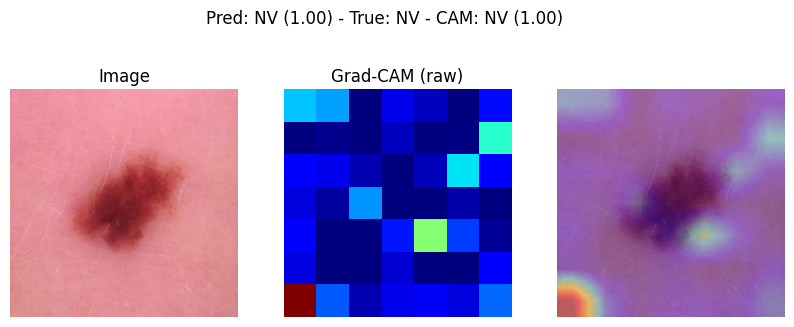

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034409.jpg | pred=BCC (0.981) | true=BCC | CAM target=BCC (0.981) | correct=True


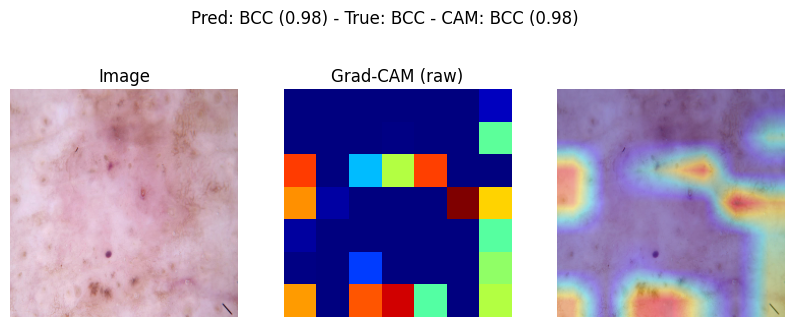

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034426.jpg | pred=NV (1.000) | true=NV | CAM target=NV (1.000) | correct=True


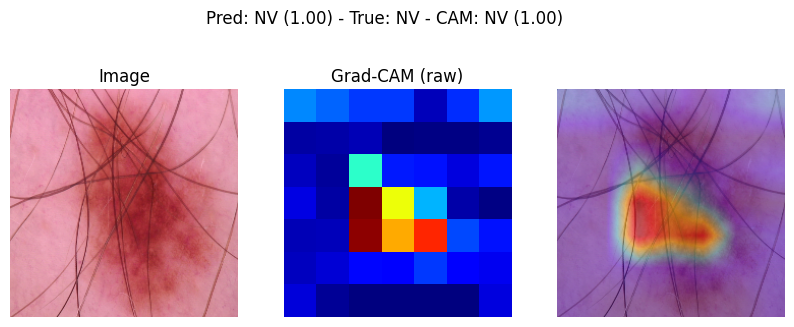

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034494.jpg | pred=MEL (0.560) | true=MEL | CAM target=MEL (0.560) | correct=True


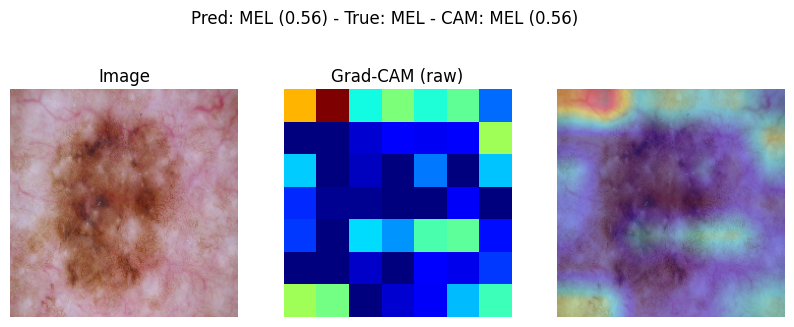

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034324.jpg | pred=NV (0.994) | true=NV | CAM target=NV (0.994) | correct=True


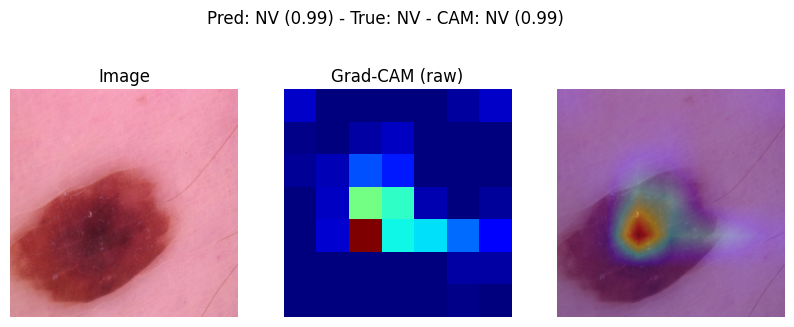

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam

Grad-CAM on a few misclassifications (randomized):
[Grad-CAM] ISIC_0034523.jpg | pred=AKIEC (0.707) | true=BCC | CAM target=AKIEC (0.707) | correct=False


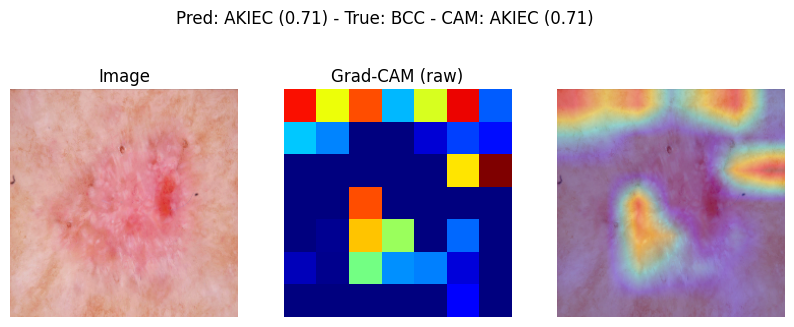

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034450.jpg | pred=BCC (0.479) | true=NV | CAM target=BCC (0.479) | correct=False


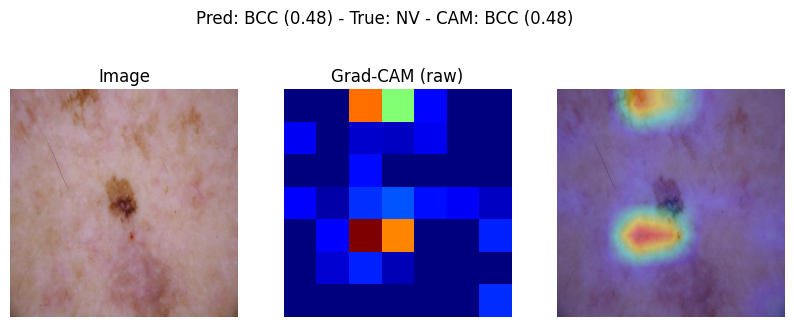

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034339.jpg | pred=MEL (0.993) | true=NV | CAM target=MEL (0.993) | correct=False


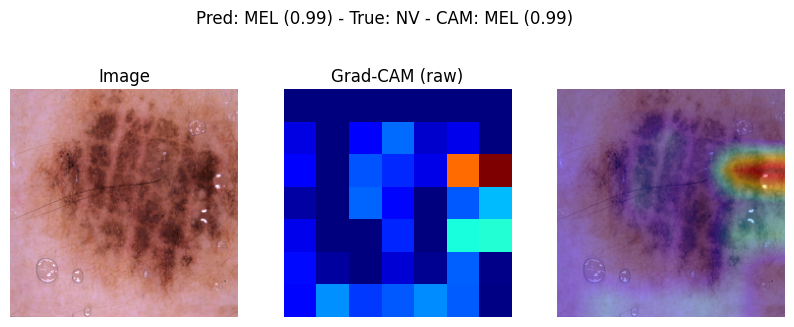

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034396.jpg | pred=NV (0.562) | true=AKIEC | CAM target=NV (0.562) | correct=False


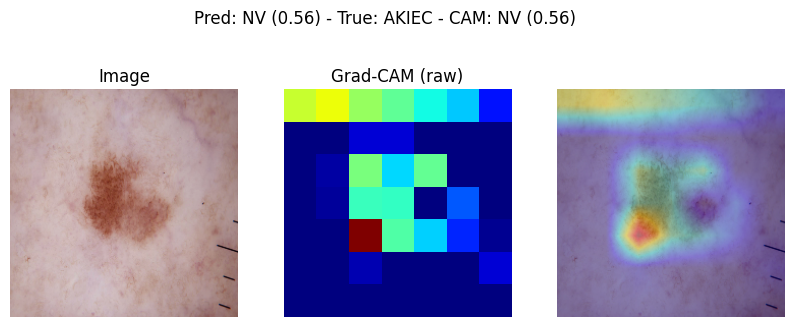

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
[Grad-CAM] ISIC_0034443.jpg | pred=BKL (0.490) | true=NV | CAM target=BKL (0.490) | correct=False


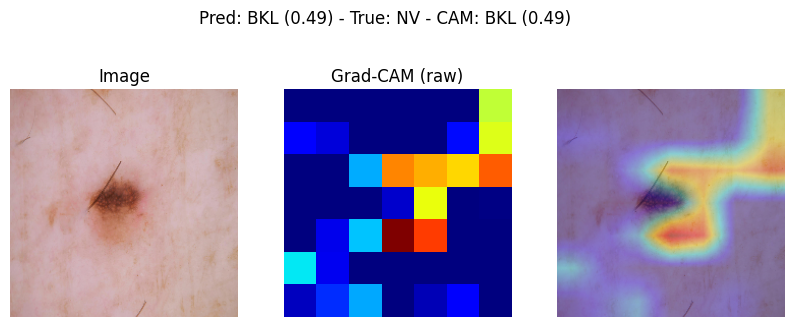

Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam
Saved files to: /content/drive/MyDrive/Deep Learning/Results/Results_Grad_Cam


In [ ]:

#Run Grad-CAM on 3 correctly predicted and 3 misclassified samples
N = 5
correct_idx = np.where(y_pred == y_val)[0]
wrong_idx   = np.where(y_pred != y_val)[0]

rng = np.random.default_rng()

#Sample up to N without replacement (handles small arrays safely)
sel_correct = rng.choice(correct_idx, size=min(N, correct_idx.size), replace=False) if correct_idx.size else []
sel_wrong   = rng.choice(wrong_idx,   size=min(N, wrong_idx.size),   replace=False) if wrong_idx.size   else []

print("\nGrad-CAM on a few correct predictions (randomized):")
for i in sel_correct:
    _ = gradcam_on_test_index(i)
    _ = save_gradcam_for_index(i)

print("\nGrad-CAM on a few misclassifications (randomized):")
for i in sel_wrong:
    _ = gradcam_on_test_index(i)
    _ = save_gradcam_for_index(i)

#One random example (from whichever set is non-empty)
pool = np.concatenate([sel_correct, sel_wrong]) if (len(sel_correct) or len(sel_wrong)) else np.array([0])
i = int(rng.choice(pool))
_ = save_gradcam_for_index(i)


In [ ]:
#build a CSV summarizing predictions, confidences and per class probabilities
summary = pd.DataFrame({
    "image_id": val_ids,
    "true_label_idx": y_val,
    "true_label": [CLASS_NAMES[i] for i in y_val],
    "pred_label_idx": y_pred,
    "pred_label": [CLASS_NAMES[i] for i in y_pred],
    "top1_confidence": top1_conf
})
#add all per-class probabilities
for k, cls in enumerate(CLASS_NAMES):
    summary[f"prob_{cls}"] = y_proba[:, k]
print("\nPreview of per-image summary with confidence:")
print(summary.head(10))

now = datetime.now()
ts = now.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(RESULTS_DIR, f"per_image_predictions_with_confidence_{ts}.csv")

#Save
summary.to_csv(out_path, index=False)


Preview of per-image summary with confidence:
           image_id  true_label_idx true_label  pred_label_idx pred_label  \
0  ISIC_0034321.jpg               1         NV               2        BCC   
1  ISIC_0034322.jpg               1         NV               1         NV   
2  ISIC_0034323.jpg               2        BCC               3      AKIEC   
3  ISIC_0034324.jpg               1         NV               1         NV   
4  ISIC_0034325.jpg               1         NV               1         NV   
5  ISIC_0034326.jpg               4        BKL               4        BKL   
6  ISIC_0034328.jpg               1         NV               1         NV   
7  ISIC_0034329.jpg               0        MEL               0        MEL   
8  ISIC_0034330.jpg               1         NV               1         NV   
9  ISIC_0034331.jpg               1         NV               1         NV   

   top1_confidence  prob_MEL   prob_NV  prob_BCC    prob_AKIEC  prob_BKL  \
0         0.843493  0.010810 